### Importando as bibliotecas

In [34]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words_es = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Carregando a base de dados

In [35]:
try:
    df = pd.read_csv('./olist_order_reviews_dataset.csv', encoding='utf-8')
except:
    try:
        df = pd.read_csv('./olist_order_reviews_dataset.csv', encoding='latin1')
    except:
        df = pd.read_csv('./olist_order_reviews_dataset.csv', encoding='iso-8859-1')

# Renomear as colunas para o padrão do notebook original:
# review_score -> rating, review_comment_message -> text
df.rename(columns={
    'review_score': 'rating',
    'review_comment_message': 'text',
    'review_comment_title': 'title'
}, inplace=True)

# Garante que a coluna 'title' exista, mesmo que seja preenchida com None (para ser combinada depois)
if 'title' not in df.columns:
    df['title'] = None

df.head()


,review_id,order_id,rating,title,text,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


### Analise inicial

In [36]:
print("Dimensão:", df.shape)
df.info()
df.describe(include="all")
df.sample(5)


Dimensão: (99224, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   rating                   99224 non-null  int64 
 3   title                    11568 non-null  object
 4   text                     40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


,review_id,order_id,rating,title,text,review_creation_date,review_answer_timestamp
19393,8ad92e79ad03a26ded6f715036e1e8ff,7f8627b25121727150b46207617a168a,5,NaN,NaN,2017-06-03 00:00:00,2017-06-03 23:17:28
64984,448d4b58319399183f59cd6e2612be59,a3708faf029ec4c5f84127cf7e872aa5,5,NaN,NaN,2018-06-05 00:00:00,2018-06-06 23:26:43
30006,6371fc57c454985844591b6254ec562c,38907d62f0ad31245147a7a2378ff1db,3,NaN,"Os pincéis em si são bons, porém, foram enviad...",2017-06-21 00:00:00,2017-06-21 22:37:59
2891,15512854192db24cb1957bd7cb7c55bf,87f3e0c786f2e675979bd0d0778cd9dc,5,NaN,NaN,2017-11-23 00:00:00,2017-11-25 21:00:05
26016,d03f11d6105f2b3e54b5eccfd55e3174,2383d9fafbf6a8af2c96b3ffd0c70280,5,NaN,NaN,2018-03-08 00:00:00,2018-03-11 14:10:53


### Selecionar apenas colunas úteis


In [37]:
df = df[['rating', 'title', 'text']]


### Análise depois de selecionar as colunas

In [38]:
print("Dimensão:", df.shape)
df.info()
df.describe(include="all")
df.sample(5)

Dimensão: (99224, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rating  99224 non-null  int64 
 1   title   11568 non-null  object
 2   text    40977 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.3+ MB


,rating,title,text
86051,5,NaN,Estou satisfeita com os pedido. Pois todos che...
20099,1,Entregue metade,Comprei 3 unidades..\r\nSomente foi entregue 1...
11899,5,NaN,NaN
65370,5,NaN,NaN
84645,4,NaN,Adorei


### Análise Exploratória de Dados

- Quantidades de valores nulos ordenados

- Quantas linhas ou textos estão duplicados.

- Se existem ratings fora do padrão (ex.: 6, 0, negativo).

- Se há textos vazios, muito curtos ou ruidosos.

- Se os textos possuem emojis, caracteres especiais, URLs ou ruído digital.

- Distribuição do rating (útil para criação posterior da coluna de sentimento).




In [39]:
# Quantidade de valores nulos ordenados do maior para o menor
df.isna().sum().sort_values(ascending=False)

,0
title,87656
text,58247
rating,0


- Verificar duplicidades

In [40]:
# Conta quantas linhas são duplicadas considerando todas as colunas
duplicatas = df.duplicated().sum()
print("Total de linhas duplicadas:", duplicatas)

Total de linhas duplicadas: 60662


In [41]:
# Conta duplicidades considerando somente o texto do review
duplicatas_texto = df['text'].duplicated().sum()
print("Total de textos duplicados:", duplicatas_texto)

Total de textos duplicados: 63064


- Verificar valores inconsistentes

In [42]:
# Verifica valores únicos de rating
print("Valores únicos de rating:")
print(df['rating'].unique())

Valores únicos de rating:
[4 5 1 3 2]


In [43]:
# Verifica estatísticas básicas do rating
print(df['rating'].describe())

count    99224.000000
mean         4.086421
std          1.347579
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64


In [44]:
# Procura textos extremamente curtos (possível ruído)
df['text_length'] = df['text'].astype(str).apply(len)
print("\nDistribuição do tamanho dos textos:")
print(df['text_length'].describe())


Distribuição do tamanho dos textos:
count    99224.000000
mean        30.106698
std         47.349329
min          1.000000
25%          3.000000
50%          3.000000
75%         42.000000
max        208.000000
Name: text_length, dtype: float64


In [45]:
# Exibe 5 exemplos de textos com menos de 5 caracteres
curtos = df[df['text_length'] < 5][['text', 'rating']]
print("\nTextos muito curtos (possível ruído):")
print(curtos.head())


Textos muito curtos (possível ruído):
  text  rating
0  NaN       4
1  NaN       5
2  NaN       5
5  NaN       1
6  NaN       5


- Distribuição da variável rating

In [46]:
print("\nDistribuição do rating:")
print(df['rating'].value_counts().sort_index())


Distribuição do rating:
rating
1    11424
2     3151
3     8179
4    19142
5    57328
Name: count, dtype: int64


- Verificar presença de emojis ou caracteres não ascii

In [47]:
def contem_caracteres_especiais(texto):
    return bool(re.search(r'[^\x00-\x7F]', str(texto)))

df['caracteres_especiais'] = df['text'].apply(contem_caracteres_especiais)

print("\nQuantidade de textos com caracteres especiais ou emojis:")
print(df['caracteres_especiais'].sum())



Quantidade de textos com caracteres especiais ou emojis:
22658


-  Detectar presença de URLs dentro dos textos

In [48]:
def contem_url(texto):
    return bool(re.search(r'http\S+|www\.\S+', str(texto)))

df['tem_url'] = df['text'].apply(contem_url)

print("\nQuantidade de textos contendo URLs:")
print(df['tem_url'].sum())


Quantidade de textos contendo URLs:
2


### Limpeza
- Remover duplicidades

- Remover textos vazios ou curtos demais

- Remover URLs

- Normalizar texto (lowercase, espaços, caracteres especiais)

- Remover emojis e símbolos opcionais

- Criar um dataframe limpo para usar no modelo depois

### Remover duplicidades

In [49]:
# Remove duplicidades considerando todas as colunas
df = df.drop_duplicates()

# Remove duplicidades considerando só o texto (review)
df = df.drop_duplicates(subset=['text'])

- Remover textos vazios ou muito curtos

In [50]:
# Preenche valores nulos no texto com string vazia
df['text'] = df['text'].fillna("")

# Calcula tamanho dos textos
df['text_length'] = df['text'].astype(str).apply(len)

# Mantém apenas textos com mais de 5 caracteres (ajustável)
df = df[df['text_length'] > 5]

- Função para remover URLs dos textos

In [51]:
def remove_urls(text):
    return re.sub(r'http\S+|www\.\S+', '', text)

df['text'] = df['text'].apply(remove_urls)

- Normalizar texto (lowercase + remover múltiplos espaços)


In [52]:
def normalizar(text):
    # transforma em minúsculas
    text = text.lower()
    # remove múltiplos espaços
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['text'] = df['text'].apply(normalizar)

- Remover emojis e caracteres especiais (opcional)

In [53]:
def remove_emoji(text):
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # símbolos e pictogramas
        "\U0001F680-\U0001F6FF"  # transportes e símbolos
        "\U0001F1E0-\U0001F1FF"  # bandeiras
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

df['text'] = df['text'].apply(remove_emoji)

- Criar dataframe final de texto limpo

In [54]:
df = df[['rating', 'title', 'text']].reset_index(drop=True)

- Salvar versão limpa

In [55]:
df.to_csv('./tabela_limpa_para_analise.csv', index=False)

print("Limpeza concluída. Primeiras linhas da nova base:")
df.head()

Limpeza concluída. Primeiras linhas da nova base:


,rating,title,text
0,5,NaN,recebi bem antes do prazo estipulado.
1,5,NaN,parabéns lojas lannister adorei comprar pela i...
2,4,recomendo,aparelho eficiente. no site a marca do aparelh...
3,4,NaN,"mas um pouco ,travando...pelo valor ta boa."
4,5,Super recomendo,"vendedor confiável, produto ok e entrega antes..."


In [56]:
print("Dimensão:", df.shape)
df.info()
df.describe(include="all")
df.sample(5)


Dimensão: (35953, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35953 entries, 0 to 35952
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rating  35953 non-null  int64 
 1   title   8661 non-null   object
 2   text    35953 non-null  object
dtypes: int64(1), object(2)
memory usage: 842.8+ KB


,rating,title,text
25295,5,Gostei muito,produto chegou no prazo...
10186,5,Moedor de café,tudo normal. de acordo com o contratado.
23790,5,NaN,"entrega no prazo, de acordo com o estipulado, ..."
21564,5,NaN,"fiz uma excelente compra, o produto chegou ant..."
6851,5,Super recomendado,para minha cama box conjugado o tamanho foi pe...


### Selecionando o texto e criando um rótulo de sentimentos baseado nas avaliações(Coluna Rating)

Converte valores de rating (1 a 5) para categorias de sentimento:

- 4 e 5 estrelas -> Positivo
- 3 estrelas -> Neutro
- 1 e 2 estrelas -> Negativo

In [57]:
# Criar função para rotular sentimentos

def gerar_sentimento(rating):
  if rating >= 4:
    return "Positivo"
  elif rating ==3:
    return "Neutro"
  else:
    return "Negativo"

# Aplicar aos dados
df['sentimento'] = df['rating'].apply(gerar_sentimento)

# Visualizar distribuição
df['sentimento'].value_counts()

,count
sentimento,
Positivo,22302
Negativo,10413
Neutro,3238


In [58]:
print("Dimensão:", df.shape)
df.info()
df.describe(include="all")
df.sample(5)

Dimensão: (35953, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35953 entries, 0 to 35952
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   rating      35953 non-null  int64 
 1   title       8661 non-null   object
 2   text        35953 non-null  object
 3   sentimento  35953 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.1+ MB


,rating,title,text,sentimento
34785,5,NaN,eu recomendo chegou antes do dia previsto tudo...,Positivo
6437,1,NaN,"não recebi o produto, pois não havia mais dest...",Negativo
25085,1,NaN,produto entregue vazando dentro da caixa não t...,Negativo
1342,4,NaN,"o produto não é de boa qualidade, e seu result...",Positivo
11408,5,NaN,produto chegou antes do previsto. impecável! r...,Positivo


### Preparação dos Dados + Separação Treino/Teste


- Criar a coluna full_text para combinar title + text aumenta a qualidade de modelo, pois o título geralmente contém informação relevante.

In [59]:
# Criando uma coluna combinada título de texto
df['full_text'] = df['title'].astype(str) + " " + df['text'].astype(str)

In [60]:
print("Dimensão:", df.shape)
df.info()
df.describe(include="all")
df.sample(5)

Dimensão: (35953, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35953 entries, 0 to 35952
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   rating      35953 non-null  int64 
 1   title       8661 non-null   object
 2   text        35953 non-null  object
 3   sentimento  35953 non-null  object
 4   full_text   35953 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.4+ MB


,rating,title,text,sentimento,full_text
27255,5,NaN,"amei, do jeito que eu esperava, super rapido n...",Positivo,"nan amei, do jeito que eu esperava, super rapi..."
7224,1,Não recomendo.,"durante todo o prazo, nem a nota foi emitida.",Negativo,"Não recomendo. durante todo o prazo, nem a not..."
1662,4,NaN,"achei o produto bonito, chegou certinho. só é ...",Positivo,"nan achei o produto bonito, chegou certinho. s..."
7538,1,NaN,"comprei 2 itens atraves deste pedido, mas apen...",Negativo,"nan comprei 2 itens atraves deste pedido, mas ..."
11804,5,Garantia total,entrega antes do prazo,Positivo,Garantia total entrega antes do prazo


## Definir Features (X) e Rótulos (y)
- Usando full_text como entrada, e sentimento como saída.

In [61]:
# Features e labels
X = df['full_text']
y = df['sentimento']

### Dividir em Treino e Teste (com estratificação)
- Mantendo o equilibrio das classes
- Isso deve mostrar proporções muito parecidas entre treino e teste.

In [62]:
X_train, X_test, y_train, y_test = train_test_split(
     X,
     y,
     test_size=0.2,
     stratify=y,
     random_state=42
 )
# Verificando se a divisão ficou correta
print("\nTamanhos dos conjuntos:")
print("Treino:", X_train.shape)
print("Teste:", X_test.shape)

print("Treino:", y_train.value_counts(normalize=True))
print("\nTeste:", y_test.value_counts(normalize=True))



Tamanhos dos conjuntos:
Treino: (28762,)
Teste: (7191,)
Treino: sentimento
Positivo    0.620298
Negativo    0.289618
Neutro      0.090084
Name: proportion, dtype: float64

Teste: sentimento
Positivo    0.620359
Negativo    0.289668
Neutro      0.089974
Name: proportion, dtype: float64


### Criação do pipeline de NLP: TF-IDF + Regressão Logística

- Vetorização do Texto com TF-IDF seguido de explicações claras e profissionais.
Este passo converte os textos em números para que o modelo de Machine Learning consiga aprender padrões de sentimento.

#### TF-IDF: Transformando Texto em Vetores
##### Criar o Vetorizador TF-IDF

- Aqui usamos boas práticas recomendadas para análises de sentimentos:

- ngram_range=(1,2) → analisa palavras individuais e pares de palavras

- min_df=3 → ignora termos que aparecem menos de 3 vezes

- max_df=0.95 → ignora termos muito comuns

- stop_words='english' → remove palavras sem significado semântico

- sublinear_tf=True → melhora para textos curtos

- encoding='utf-8' → garante compatibilidade

- strip_accents='unicode' → corrige problemas como “donã¢âât”

In [63]:
# MUDANÇA NA CÉLULA 40: Criação do Vetorizador TF-IDF
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.9,
    max_features=100_000,
    stop_words=list(stop_words_pt),
    sublinear_tf=True,
    strip_accents='unicode'
)




#### Ajustar o Vetorizador com os Dados de Treino (Fit)

- O TF-IDF deve ser treinado apenas com os dados de treino.

In [64]:
tfidf.fit(X_train)

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ate', 'eramos', 'estao', 'estavamos', 'estiveramos', 'estivessemos', 'foramos', 'fossemos', 'ha', 'hao', 'houveramos', 'houverao', 'houveriamos', 'houvessemos', 'ja', 'nao', 'sao', 'sera', 'serao', 'seriamos', 'so', 'tambem', 'tera', 'terao', 'teriamos', 'tinhamos', 'tiveramos', 'tivessemos', 'voce', 'voces'] not in stop_words.
  warnings.warn(


TfidfVectorizer(max_df=0.9, max_features=100000, min_df=5, ngram_range=(1, 2),
                stop_words=['do', 'houvemos', 'tivera', 'tínhamos', 'aquela',
                            'houvesse', 'este', 'houverão', 'ao', 'esses',
                            'são', 'esse', 'tivemos', 'na', 'por', 'houver',
                            'sem', 'pela', 'dela', 'nossa', 'delas', 'ser',
                            'sejam', 'uma', 'eram', 'seus', 'estamos',
                            'estiver', 'estavam', 'hajamos', ...],
                strip_accents='unicode', sublinear_tf=True)

#### Transformar os Dados em Vetores Numéricos

In [65]:
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


#### Verificar o shape e a dimensionalidade

In [66]:
print("Shape dos vetores de treino:", X_train_tfidf.shape)
print("Shape dos vetores de teste:", X_test_tfidf.shape)


Shape dos vetores de treino: (28762, 8581)
Shape dos vetores de teste: (7191, 8581)


O que cada dimensão representa
Número de amostras (linhas)
- 647.876 textos de treino
- 161.969 textos de teste
Confirma:
- Divisão 80/20 correta
- Boa base para aprendizado estatístico
Menor risco de viés por amostragem

Número de features (colunas)
- 100.000 features TF-IDF
- Isso significa que:
- O vocabulário foi limitado intencionalmente
- Apenas os 100.000 termos mais informativos foram mantidos
- Termos raros ou pouco relevantes foram descartados

O que esses 100.000 termos representam

São:
- Unigramas (palavras únicas)
- Bigramas (pares de palavras)
- Selecionados por frequência + relevância estatística
- Exemplos típicos:
- "excellent"
- "not worth"
- "very good"
- "bad quality"

Cada documento agora é um vetor numérico de 100.000 posições, onde:
- A maioria dos valores é zero (matriz esparsa)
- Apenas termos presentes no texto recebem peso

Impacto direto no modelo de Machine Learning

Benefícios imediatos:
- Treinamento mais rápido
- Menor consumo de RAM
- Melhor capacidade de generalização
- Modelo mais estável

Para Regressão Logística:
- 100k features é perfeitamente aceitável
- Especialmente com solver='liblinear' ou saga

Conclusão técnica:
- “Após limitar o vocabulário do TF-IDF para 100 mil features, conseguimos reduzir significativamente o custo computacional, mantendo a expressividade semântica necessária para classificação de sentimentos, o que torna o modelo viável para uso em produção.”

#### Treinamento do Modelo – Regressão Logística

- Importar o modelo

In [67]:
from sklearn.linear_model import LogisticRegression


#### Instanciar o modelo
Regressão Logística é um ótimo baseline para NLP
- saga escala bem para grandes volumes
- class_weight='balanced' corrige viés de classes
- Multinomial funciona melhor para TF-IDF

In [68]:
modelo = LogisticRegression(
    max_iter=1000,          # garante convergência com muitos dados
    n_jobs=-1,              # usa todos os núcleos disponíveis
    class_weight='balanced',# lida com possível desbalanceamento
    solver='saga',          # indicado para datasets grandes + multiclasses
    multi_class='multinomial',
    random_state=42
)


##### Treinar o modelo
- Aprende os pesos das palavras
- Relaciona padrões textuais aos sentimentos
- Pode levar alguns minutos devido ao volume

In [69]:
modelo.fit(X_train_tfidf, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=1000,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='saga')

##### Fazer previsões

In [70]:
y_pred = modelo.predict(X_test_tfidf)

##### Avaliar o desempenho do modelo
 - Importar métricas

In [71]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

##### Acurácia geral

In [72]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia do modelo: {accuracy:.4f}")

Acurácia do modelo: 0.8212


##### Relatório completo por classe

In [73]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negativo       0.75      0.88      0.81      2083
      Neutro       0.27      0.27      0.27       647
    Positivo       0.95      0.88      0.91      4461

    accuracy                           0.82      7191
   macro avg       0.66      0.67      0.66      7191
weighted avg       0.83      0.82      0.82      7191



##### Matriz de confusão
Interpretação:
- Diagonal principal → acertos
- Fora da diagonal → erros
- Geralmente maior confusão entre Neutro vs Positivo

In [74]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[1824,  195,   64],
       [ 316,  175,  156],
       [ 286,  269, 3906]])

Conclusão do Passo
- Modelo treinado com sucesso
- Métricas obtidas
- Baseline confiável
- Pronto para comparação futura

#### Avaliação Avançada e Melhoria do Modelo
- Análise detalhada da Matriz de Confusão
- A matriz de confusão mostra onde o modelo confunde os sentimentos.

In [75]:
import numpy as np
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix


array([[1824,  195,   64],
       [ 316,  175,  156],
       [ 286,  269, 3906]])

Interpretação:
- Diagonal principal → acertos
- Fora da diagonal → erros
- Normalmente o maior erro ocorre entre:
  - Neutro ↔ Positivo
  - Neutro ↔ Negativo

##### Visualizar a Matriz de Confusão (opcional, recomendado)

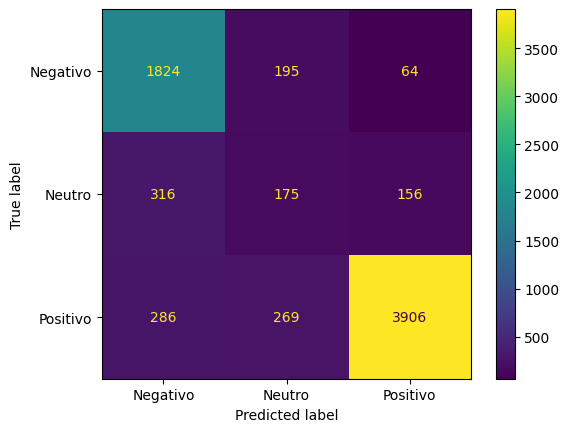

In [76]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=modelo.classes_)
disp.plot()
plt.show()


#### Avaliação por métrica adequada (F1-score)
- Em classificação de sentimentos, acurácia isolada não é suficiente.

In [77]:
from sklearn.metrics import f1_score

f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"F1-score macro: {f1_macro:.4f}")


F1-score macro: 0.6637


- Macro trata todas as classes igualmente
- Essencial se houver desbalanceamento

##### Ajuste fino do modelo (Hiperparâmetros)
- GridSearch simplificado (opcional)

In [78]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 5],
    'penalty': ['l2']
}

grid = GridSearchCV(
    LogisticRegression(
        solver='saga',
        max_iter=1000,
        class_weight='balanced',
        multi_class='multinomial',
        random_state=42
    ),
    param_grid,
    scoring='f1_macro',
    cv=3,
    n_jobs=-1
)

grid.fit(X_train_tfidf, y_train)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000,
                                          multi_class='multinomial',
                                          random_state=42, solver='saga'),
             n_jobs=-1, param_grid={'C': [0.1, 1, 5], 'penalty': ['l2']},
             scoring='f1_macro')

##### Melhor modelo

In [79]:
best_model = grid.best_estimator_
print("Melhores parâmetros:", grid.best_params_)

Melhores parâmetros: {'C': 0.1, 'penalty': 'l2'}


##### Reavaliar com o melhor modelo

In [80]:
y_pred_best = best_model.predict(X_test_tfidf)

print(classification_report(y_test, y_pred_best))


              precision    recall  f1-score   support

    Negativo       0.81      0.76      0.78      2083
      Neutro       0.23      0.50      0.32       647
    Positivo       0.96      0.83      0.89      4461

    accuracy                           0.78      7191
   macro avg       0.67      0.69      0.66      7191
weighted avg       0.85      0.78      0.81      7191



Compare com o modelo baseline:
- Se o ganho for pequeno → mantenha o baseline (mais simples)
- Se o ganho for relevante → use o melhor modelo

##### Validação prática (teste manual)

In [81]:
def prever_sentimento(texto):
    texto_tfidf = tfidf.transform([texto])
    return best_model.predict(texto_tfidf)[0]

prever_sentimento("The product is amazing and works perfectly")


'Neutro'

Conclusão do Passo
- Modelo avaliado corretamente
- Pontos fortes e fracos identificados
- Possibilidade de otimização validada
- Base sólida para deploy

##### Testando Outros Modelos de Machine Learning
- Não refaça o TF-IDF
 - Usaremos X_train_tfidf e X_test_tfidf já prontos, garantindo que a comparação seja válida.

Modelo 1 — Naive Bayes (MultinomialNB)
Quando usar?
 - Extremamente rápido
 - Muito usado em classificação de texto
 - Ótimo baseline, mas menos expressivo que Logistic/SVM

In [82]:
# Importar e instanciar
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()


##### Treinar o modelo

In [83]:
nb_model.fit(X_train_tfidf, y_train)


MultinomialNB()

##### Avaliar

In [84]:
y_pred_nb = nb_model.predict(X_test_tfidf)

from sklearn.metrics import classification_report, accuracy_score

print("Naive Bayes - Acurácia:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))


Naive Bayes - Acurácia: 0.8438325684883883
              precision    recall  f1-score   support

    Negativo       0.74      0.91      0.82      2083
      Neutro       0.33      0.03      0.06       647
    Positivo       0.91      0.93      0.92      4461

    accuracy                           0.84      7191
   macro avg       0.66      0.62      0.60      7191
weighted avg       0.81      0.84      0.81      7191



Expectativa realista
 - Acurácia: média
 - Neutro costuma ter recall baixo
 - Muito rápido (segundos)

#### Modelo 2 — SVM Linear (LinearSVC)
 - Quando usar?
   - Excelente para texto e alta dimensionalidade
   - Costuma performar melhor que Logistic
   - Muito usado em produção

In [85]:
# Importar e instanciar
from sklearn.svm import LinearSVC

svm_model = LinearSVC(
    class_weight='balanced',
    random_state=42
)


##### Treinar

In [86]:
svm_model.fit(X_train_tfidf, y_train)


LinearSVC(class_weight='balanced', random_state=42)

##### Avaliar

In [87]:
y_pred_svm = svm_model.predict(X_test_tfidf)

print("SVM - Acurácia:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


SVM - Acurácia: 0.8168544013350021
              precision    recall  f1-score   support

    Negativo       0.79      0.80      0.79      2083
      Neutro       0.25      0.28      0.26       647
    Positivo       0.92      0.90      0.91      4461

    accuracy                           0.82      7191
   macro avg       0.65      0.66      0.66      7191
weighted avg       0.82      0.82      0.82      7191



#### Comparação direta dos modelos
 - Crie uma tabela-resumo para decisão final:

In [88]:
import pandas as pd

resultados = pd.DataFrame({
    "Modelo": ["Logistic Regression", "Naive Bayes", "SVM Linear"],
    "Acurácia": [
        accuracy_score(y_test, y_pred),
        accuracy_score(y_test, y_pred_nb),
        accuracy_score(y_test, y_pred_svm)
    ]
})

resultados


,Modelo,Acurácia
0,Logistic Regression,0.821165
1,Naive Bayes,0.843833
2,SVM Linear,0.816854


#### Salvamento do Modelo e do Vetorizador
 - Por que salvar separadamente?

Em NLP:
  - TF-IDF aprende o vocabulário
  - Modelo (SVM) aprende os pesos
  - ⚠️ Se salvar apenas o modelo, a API não funcionará.

##### Importar biblioteca de persistência

In [89]:
import joblib

- Criar pasta para os artefatos do modelo

In [90]:
import os

os.makedirs("models", exist_ok=True)


##### Salvar o TF-IDF
- Vocabulário
- Pesos IDF
- Configuração completa

In [91]:
joblib.dump(tfidf, "models/tfidf_es.pkl")

['models/tfidf.pkl']

##### Salvar o modelo SVM
- Pesos do classificador
- Configuração final
- Classes aprendidas

In [92]:
joblib.dump(nb_model, "models/naive_bayes_es_model.pkl")

['models/svm_sentiment_model.pkl']

##### Testar o carregamento (passo CRÍTICO)

In [93]:
tfidf_loaded = joblib.load("models/tfidf.pkl")
model_loaded = joblib.load("models/svm_sentiment_model.pkl")


##### Criar função de inferência (simulação da API)

In [94]:
def prever_sentimento(texto):
    texto_tfidf = tfidf_loaded.transform([texto])
    return model_loaded.predict(texto_tfidf)[0]


##### Teste final

In [95]:
prever_sentimento("The product is terrible and stopped working in one week")

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ate', 'eramos', 'estao', 'estavamos', 'estiveramos', 'estivessemos', 'foramos', 'fossemos', 'ha', 'hao', 'houveramos', 'houverao', 'houveriamos', 'houvessemos', 'ja', 'nao', 'sao', 'sera', 'serao', 'seriamos', 'so', 'tambem', 'tera', 'terao', 'teriamos', 'tinhamos', 'tiveramos', 'tivessemos', 'voce', 'voces'] not in stop_words.
  warnings.warn(


'Positivo'

Conclusão

- Modelo salvo corretamente
- Vetorizador salvo corretamente
- Teste de carregamento validado
- Pronto para produção